In [1]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
from utils.orient import OrientUtils
from algs.uniform_sampling import UniformSampling
from evaluate.evaluator import Evaluator
from evaluate import eval_funcs
import loss_funcs
import cv2 as cv

from utils.image import ImageUtils
from tqdm.auto import tqdm
from collections import defaultdict

import scipy

In [ ]:
loss_functions = [
    loss_funcs.IOU(),
    loss_funcs.MSE(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.PeakSignalNoiseRation(),
    loss_funcs.StructuralSimilarity(),
    loss_funcs.HausdorffDistance(),
    loss_funcs.AdaptedRandError(),
    loss_funcs.VariationOfInformation(),
]

results = dict()

orients1 = OrientUtils.generate_random(5000)
orients2 = OrientUtils.generate_random(5000)

loss_dict = defaultdict(list)

init_location = (0, 1.3, 0.3)
cam_config = CameraConfig(location=(0, 0, 0.1), rotation=(np.pi / 2, 0, 0), fov=30)
sim_viewer = ViewSampler("data/world_mug_sim.xml", cam_config)

for ori1, ori2 in tqdm(zip(orients1, orients2), total=len(orients1)):
    for loss in loss_functions:    
        pos1 = ObjectPosition(ori1, init_location)
        pos2 = ObjectPosition(ori2, init_location)

        rgb1, _ = sim_viewer.get_view_cropped(pos1, depth=False, allow_simulation=False)
        rgb2, _ = sim_viewer.get_view_cropped(pos2, depth=False, allow_simulation=False)

        pad_shape = np.maximum(rgb1.shape, rgb2.shape)
        rgb1 = ImageUtils.pad_to_shape(rgb1, pad_shape)
        rgb2 = ImageUtils.pad_to_shape(rgb2, pad_shape)

        loss_val = loss(rgb1, rgb2)
        loss_dict[type(loss).__name__].append(loss_val)

In [2]:
import pickle
from pathlib import Path

def save(file_path: str, obj):
    """
    Save an object to a pickle file.

    Args:
        obj: The object to be saved.
        file_path (str): The path to the pickle file.

    Raises:
        ValueError: If there is an error saving the object to the pickle file.
    """

    Path(file_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        with open(file_path, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        raise ValueError(f"error saving object to pickle file: {e}")

def load(file_path: str) -> object:
    """
    Load an object from a pickle file.

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        The loaded object.

    Raises:
        FileNotFoundError: If the file does not exist.
        ValueError: If there is an error loading the object from the pickle file.
    """
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"file does not exist: {file_path}")
    except Exception as e:
        raise ValueError(f"error loading object from pickle file: {e}")

In [3]:
init_location = (0, 1.3, 0.3)
cam_config = CameraConfig(location=(0, 0, 0.1), rotation=(np.pi / 2, 0, 0), fov=30)
sim_viewer = ViewSampler("data/world_mug_sim.xml", cam_config)

loss_dict = load("loss_dict")
orients1 = load("ori1")
orients2 = load("ori2")

In [4]:
eval_values = []

xor_eval = eval_funcs.XorDiff(obj_depth=1.0, p_norm=1.0)

for ori1, ori2 in tqdm(zip(orients1, orients2), total=len(orients1)):
    pos1 = ObjectPosition(ori1, init_location)
    pos2 = ObjectPosition(ori2, init_location)

    depth1, _ = sim_viewer.get_view_cropped(pos1, depth=True, allow_simulation=False)
    depth2, _ = sim_viewer.get_view_cropped(pos2, depth=True, allow_simulation=False)

    pad_shape = np.maximum(depth1.shape, depth2.shape)
    depth1 = ImageUtils.pad_to_shape(depth1, pad_shape)
    depth2 = ImageUtils.pad_to_shape(depth2, pad_shape)

    depth1[depth1 > 20] = 0
    depth2[depth2 > 20] = 0

    eval_val = xor_eval(depth1, depth2)
    eval_values.append(eval_val)

  0%|          | 0/5000 [00:00<?, ?it/s]

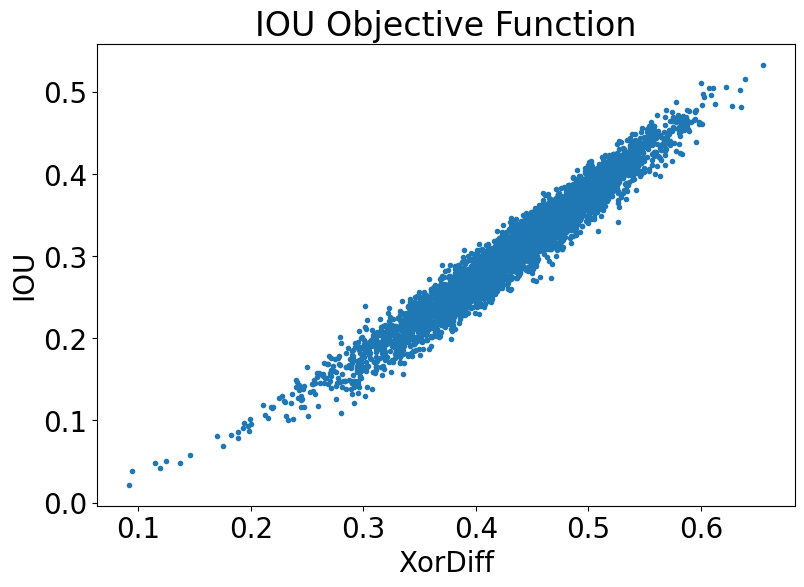

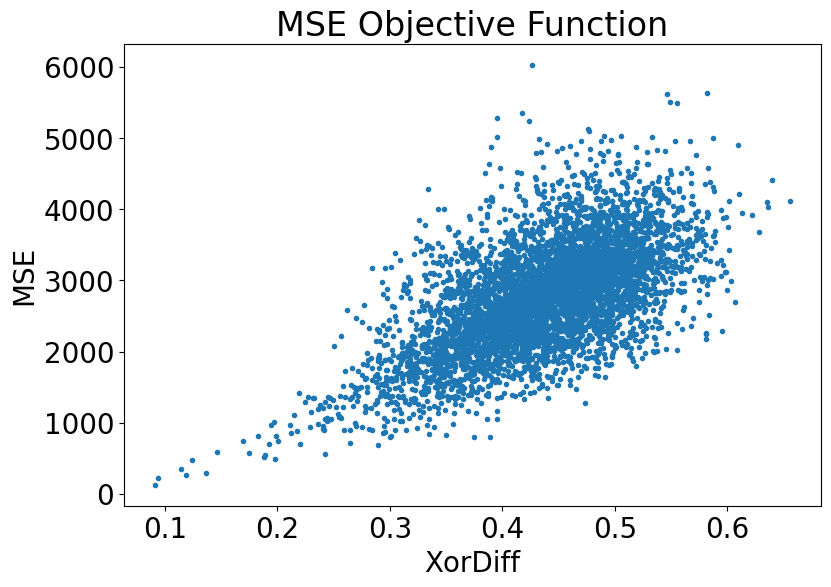

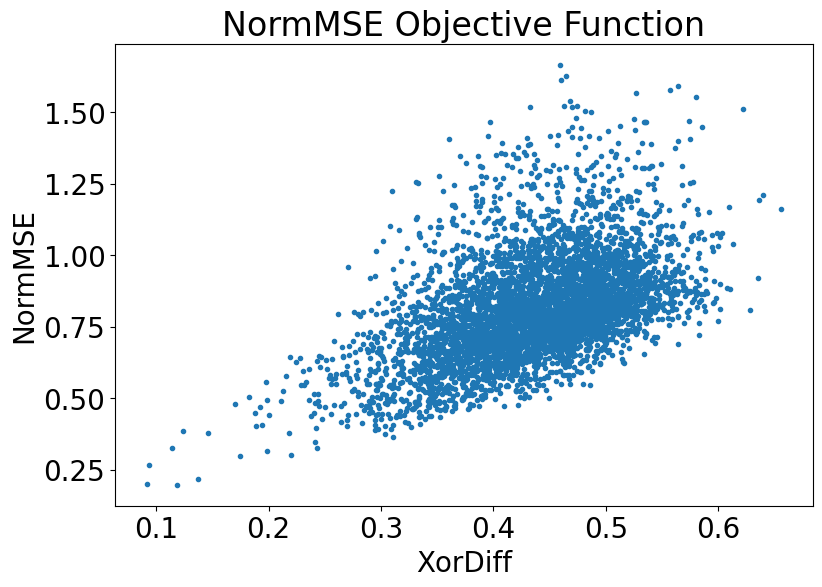

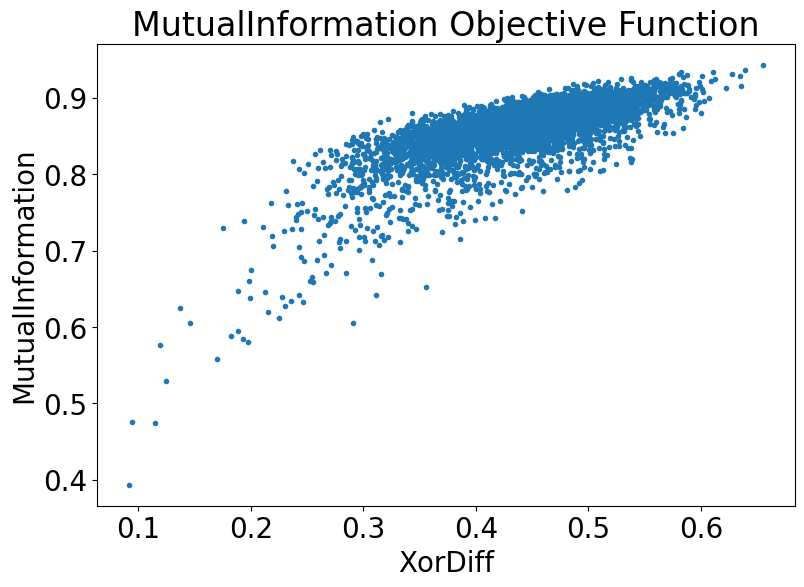

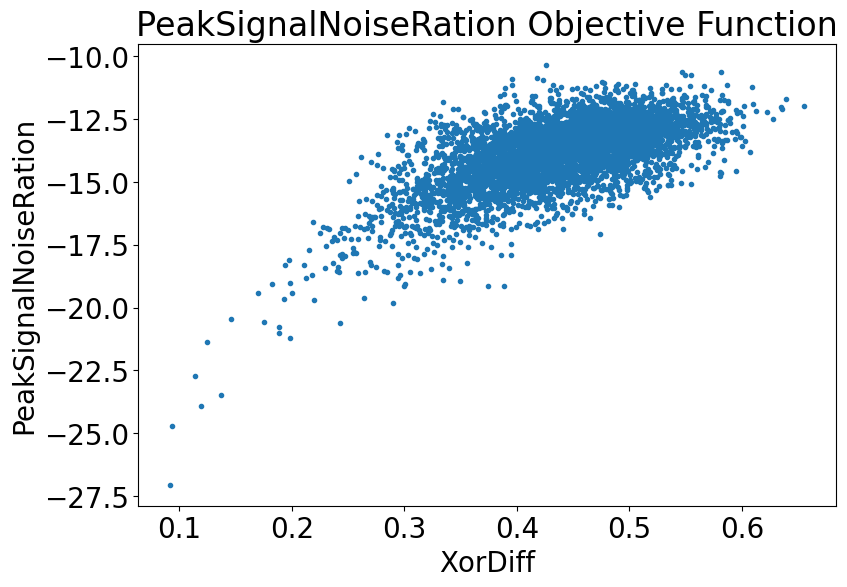

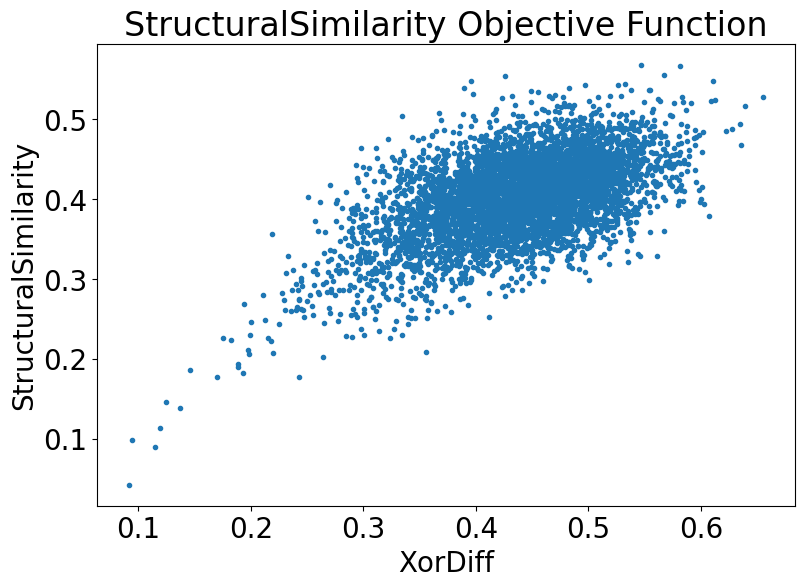

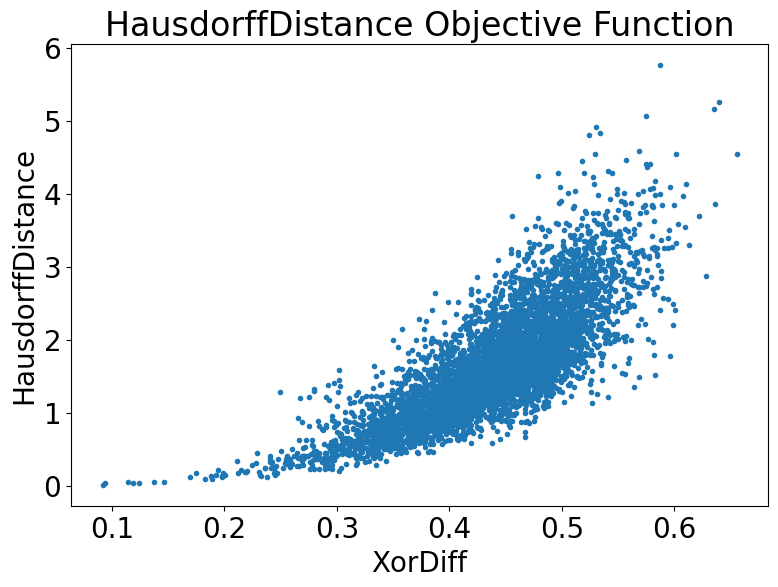

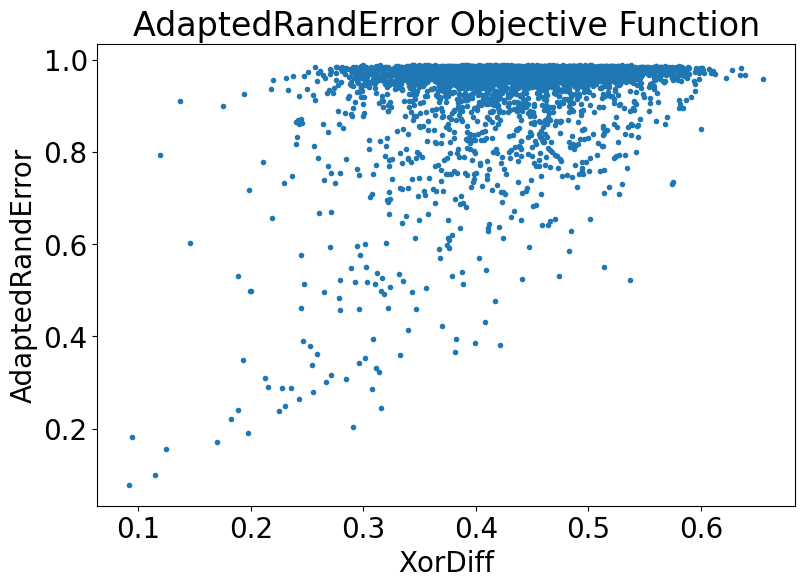

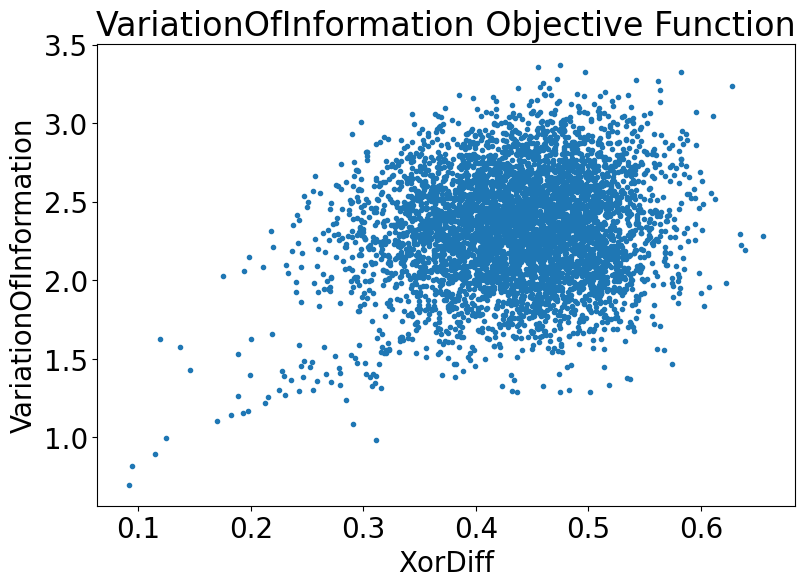

In [9]:
from matplotlib import pyplot as plt

font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = False

for i, (loss, values) in enumerate(loss_dict.items()):
    fig = plt.figure(i, figsize=(9, 6))
    fig.clear()
    ax = fig.add_subplot(111)
    ax.set_xlabel("XorDiff")
    ax.set_ylabel(loss)
    ax.set_title(f"{loss} Objective Function")
    plt.plot(eval_values, values, '.', label=loss)

In [ ]:
cam_config = CameraConfig(location=(0, 0, 0.1), rotation=(np.pi / 2, 0, 0), fov=30)
world_viewer = ViewSampler("data/world_mug.xml", cam_config, simulation_time=0)
sim_viewer = ViewSampler("data/world_mug_sim.xml", cam_config)

init_location = (0, 1.3, 0.3)
random_orientations = OrientUtils.generate_random(200)
pos1 = [ObjectPosition(orient, init_location) for orient in random_orientations]

In [ ]:
loss_functions = [
    loss_funcs.IOU(),
    loss_funcs.MSE(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.PeakSignalNoiseRation(),
    loss_funcs.StructuralSimilarity(),
    loss_funcs.HausdorffDistance(),
    loss_funcs.AdaptedRandError(),
    loss_funcs.VariationOfInformation(),
]

alg_config = UniformSampling.Config(time_limit=1000, min_samples=343, randomized=False, silent=True)

evaluator = Evaluator(world_viewer, eval_func=eval_funcs.NormXorDiff(obj_depth=2.0, p_norm="mse"))

results = dict()

for loss in loss_functions:
    alg = UniformSampling(sim_viewer, loss_func=loss)
    alg.register_callback()
    eval_values = evaluator.evaluate(alg, alg_config, pos1)
    results[type(loss).__name__] = eval_values
    print(f"{type(loss).__name__}: {eval_values}")

cv.destroyAllWindows()


TypeError: Algorithm.register_callback() missing 1 required positional argument: 'callback'

In [ ]:
print(results)

In [ ]:
import statistics

for loss, eval_values in results.items():
    print(f"{loss}: {statistics.mean(eval_values)}")
    print(f"{loss}: {statistics.median(eval_values)}")

In [ ]:
results["NMSE"] = results.pop("NormMSE")
results["NMI"] = results.pop("MutualInformation")
results["PSNR"] = results.pop("PeakSignalNoiseRation")
results["SSIM"] = results.pop("StructuralSimilarity")
results["Hausdorff"] = results.pop("HausdorffDistance")
results["ARE"] = results.pop("AdaptedRandError")
results["VI"] = results.pop("VariationOfInformation")

In [ ]:
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

ax = plt.subplot(111)

ax.set_title('XorDiff Value per UniformSampling and Different Objective Functions')
ax.boxplot(results.values(), labels=results.keys(), sym="", patch_artist=False, autorange=True)
ax.set_ylabel('XorDiff Value')